In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

#Tensorflow
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential,save_model,load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.metrics import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
import keras

#Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [9]:
pip install openpyxl

  Using cached openpyxl-3.1.5-py2.py3-none-any.whl.metadata (2.5 kB)
  Using cached et_xmlfile-2.0.0-py3-none-any.whl.metadata (2.7 kB)
Using cached openpyxl-3.1.5-py2.py3-none-any.whl (250 kB)
Using cached et_xmlfile-2.0.0-py3-none-any.whl (18 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
import pandas as pd

# Lee el archivo Excel
df = pd.read_excel('IMPORTACIONES.xlsx')

# Guarda como CSV
df.to_csv('IMPORTACIONES.csv', index=False)

In [14]:
tf.random.set_seed(123)
# Make sure the file name is correct and includes the extension, e.g., 'IMPORTACIONES.csv'
imp = pd.read_csv("IMPORTACIONES.csv", parse_dates=['Fecha'], index_col='Fecha')
print('\n Parsed Data:')
print(imp.head())

# ...existing code...
# Agrupa por año y suma los valores de cada columna
imp_anual = imp.resample('Y').sum()

# Si solo quieres ver la columna Diesel por año:
diesel_anual = imp['Diesel'].resample('Y').sum()

print(diesel_anual)
# ...existing code...



 Parsed Data:
            Aceites lubricantes  Asfalto      Bunker  Ceras  \
Fecha                                                         
2001-01-01                  0.0  27748.99  214581.84    0.0   
2001-02-01                  0.0   7503.57  294609.00    0.0   
2001-03-01                  0.0  26304.32  315263.80    0.0   
2001-04-01                  0.0   7885.89  205653.00    0.0   
2001-05-01                  0.0   8443.16  278371.30    0.0   

            Combustible turbo jet     Diesel  Diesel ultra bajo azufre  \
Fecha                                                                    
2001-01-01                    0.0  566101.99                       0.0   
2001-02-01                    0.0  489525.80                       0.0   
2001-03-01                    0.0  575559.68                       0.0   
2001-04-01                    0.0  437745.42                       0.0   
2001-05-01                    0.0  552609.13                       0.0   

            Gas licuado 

C:\Users\Javier Chiquin\AppData\Local\Temp\ipykernel_28020\694552765.py:9: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  imp_anual = imp.resample('Y').sum()
C:\Users\Javier Chiquin\AppData\Local\Temp\ipykernel_28020\694552765.py:12: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  diesel_anual = imp['Diesel'].resample('Y').sum()


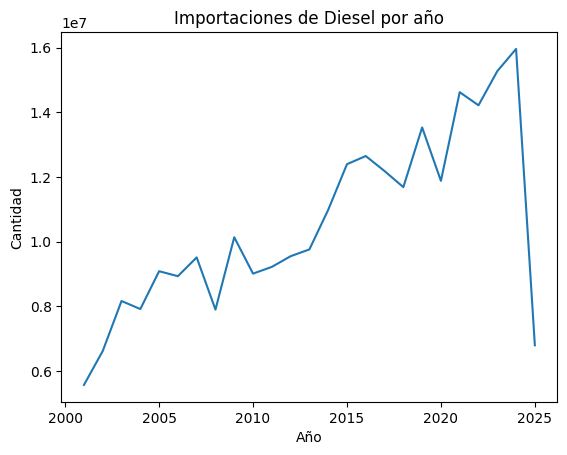

In [ ]:
plt.plot(diesel_anual.index.year, diesel_anual.values)
plt.gca().set(title="Importaciones de Diesel por año", xlabel="Año", ylabel="Cantidad")
plt.show()

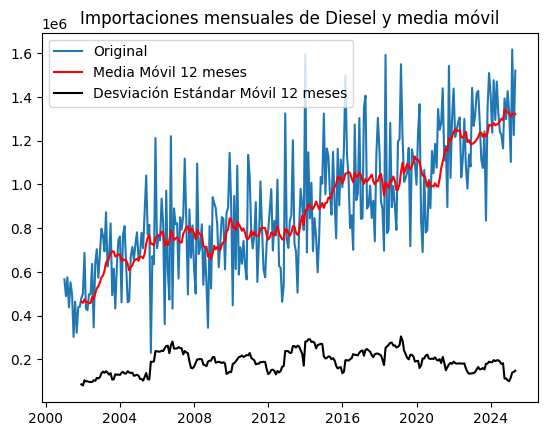

In [26]:
# Descomposición estacional
mediaMovil = imp['Diesel'].rolling(window=12).mean()
deMovil = imp['Diesel'].rolling(window=12).std()
plt.plot(imp['Diesel'], label='Original')
plt.plot(mediaMovil, label='Media Móvil 12 meses', color='red')
plt.plot(deMovil, label='Desviación Estándar Móvil 12 meses', color='black')
plt.legend()
plt.title('Importaciones mensuales de Diesel y media móvil')
plt.show()


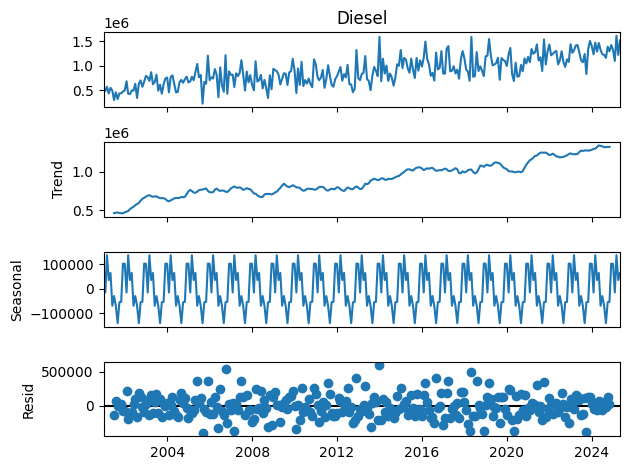

In [28]:
# Descomposición estacional sobre la serie mensual de Diesel
descomposicion = seasonal_decompose(imp['Diesel'], model='additive', period=12)
descomposicion.plot()
plt.show()


Tendencia (Trend): Se observa una tendencia creciente a lo largo de los años, con algunos periodos de estabilidad y repuntes, lo que indica un aumento sostenido en las importaciones de Diesel.

Estacionalidad (Seasonal): Ahora sí se detecta un patrón estacional claro, con oscilaciones regulares cada año. Esto significa que hay meses en los que las importaciones tienden a subir o bajar de forma recurrente, probablemente por factores económicos, climáticos o de demanda.

Residuales (Resid): Los residuales muestran variabilidad alrededor de cero, lo que indica que el modelo de descomposición logra capturar bien la tendencia y la estacionalidad, aunque aún hay cierta variabilidad no explicada (ruido).

In [29]:
print('Resultados del Test de Dickey Fuller')
dfTest_D = adfuller(imp['Diesel'], autolag='AIC')
salidaDf = pd.Series(dfTest_D[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest_D[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba         -0.788665
p-value                        0.822429
# de retardos usados          13.000000
# de observaciones usadas    279.000000
Critical Value (1%)           -3.454008
Critical Value (5%)           -2.871956
Critical Value (10%)          -2.572320
dtype: float64


El p-value es mayor a 0.05 por lo que no se puede rechazar la hipótesis nula de que existen raices unitarias. La serie no es estacionaria en media. Vamos a probar con una diferenciación

In [30]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
ts_imp_D_diff = imp['Diesel'].diff()
ts_imp_D_diff.fillna(0,inplace=True)
dfTest = adfuller(ts_imp_D_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba       -9.223948e+00
p-value                      1.749540e-15
# de retardos usados         1.200000e+01
# de observaciones usadas    2.800000e+02
Critical Value (1%)         -3.453922e+00
Critical Value (5%)         -2.871918e+00
Critical Value (10%)        -2.572300e+00
dtype: float64


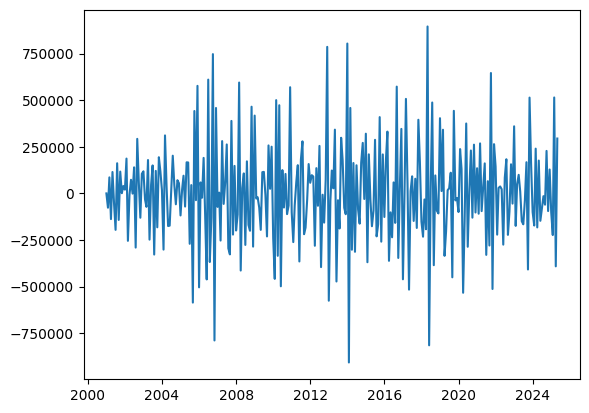

In [31]:
plt.plot(ts_imp_D_diff)

In [33]:
scaler = StandardScaler()
ts_imp_D_scaled = scaler.fit_transform(ts_imp_D_diff.values.reshape(-1, 1))
ts_imp_D_scaled[1:7]


array([[-0.29281567],
       [ 0.30360661],
       [-0.51742506],
       [ 0.40934885],
       [-0.21277562],
       [-0.72902441]])

In [34]:
val_prueba = round(0.2*len(ts_imp_D_scaled))
val_prueba

59

In [ ]:
entrenamiento = round(0.6*len(ts_imp_D_scaled))
val_prueba = round(0.2*len(ts_air_pas_scaled))
test = ts_air_pas_scaled[(entrenamiento+val_prueba)-1:]
validation = ts_air_pas_scaled[(entrenamiento):entrenamiento+val_prueba+1]
train = ts_air_pas_scaled[0:entrenamiento]
train=np.insert(train,0,0)
train=np.reshape(train,(train.shape[0],1))
len(test)